# 텍스트 분류 : 구분 → 책임구분류, 샘플링방식변경 : 랜덤샘플링

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from konlpy.tag import Okt, Kkma, Mecab, Hannanum
Okt = Okt()
kkma = Kkma()
hannanum = Hannanum()

In [3]:
df = pd.read_csv('new_data_8529.csv', sep='\t', encoding='UTF-8')

In [4]:
df.columns

Index(['std_clm_type_cd', 'ro_y', 'clm_jgmt_dt', 'ceq_caus_cd', 'ceq_psit_cd',
       'ceq_psit_nm', 'trim_plnt_cd', 'prj_vehl_cd', 'mdl_cd', 'part_sys_cd',
       'repn_part_cd', 'clm_prtl_sbc', '대상 선정', '구분', '책임구', '원인', '검토결과'],
      dtype='object')

In [5]:
df.head(3)

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---

In [6]:
df.shape

(8529, 17)

# null인 값 확인 및 제거

In [7]:
df_bak = df.copy()

In [8]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

In [9]:
df.shape

(8529, 17)

In [10]:
category_count = df['대상 선정'].value_counts()
category_count

X    5517
O    3012
Name: 대상 선정, dtype: int64

In [11]:
category_count = df['구분'].value_counts()
category_count

N          5517
기능(커넥터)    1601
실내부품이음     1050
하체이음        361
Name: 구분, dtype: int64

In [12]:
category_count = df['책임구'].value_counts()
category_count

N       5517
구매      2274
생산공장     724
연구소       14
Name: 책임구, dtype: int64

In [13]:
category_count = df['원인'].value_counts()
category_count

N        5517
부품       2274
조립불량      230
결선불량      225
체결불량      103
기타        100
미결선        37
이종/간섭      21
설계/구조      14
이물          8
Name: 원인, dtype: int64

## 1-1대상선정) 'O'값 추출

In [14]:
dfo = df.loc[df['대상 선정']=='O',:] # 대상 선정값이 O 인 것만 가져오기 (X제외)
dfo.shape

(3012, 17)

## 1-2대상선정) 'X'값 추출

In [15]:
dfx = df.loc[df['대상 선정']=='X',:] # 대상 선정값이 X인 것만 가져오기 (O제외)
dfx.shape

(5517, 17)

##    2-1구분) '하체이음'값 추출

In [18]:
df_hache = dfo.loc[dfo['구분']=='하체이음',:]
df_hache.shape

(361, 17)

In [19]:
category_count1 = df_hache['책임구'].value_counts()
category_count1

구매      249
생산공장    112
Name: 책임구, dtype: int64

## 2-2구분) '실내부품이음'값 추출

In [20]:
df_silne = dfo.loc[dfo['구분']=='실내부품이음',:]
df_silne.shape

(1050, 17)

In [21]:
category_count2 = df_silne['책임구'].value_counts()
category_count2

구매      737
생산공장    299
연구소      14
Name: 책임구, dtype: int64

## 2-3구분) '기능(커넥터)'값 추출

In [22]:
df_connect = dfo.loc[dfo['구분']=='기능(커넥터)',:]
df_connect.shape

(1601, 17)

In [23]:
category_count3 = df_connect['책임구'].value_counts()
category_count3

구매      1288
생산공장     313
Name: 책임구, dtype: int64

# '하체이음'값 '원인'분류 모델링

In [24]:
df_hache = df_hache.reindex()
df_silne = df_silne.reindex()
df_connect = df_connect.reindex()

# 전처리

In [25]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df_hache['charge_pred'] = df_hache['책임구'].astype(str).copy()
df_silne['charge_pred'] = df_silne['책임구'].astype(str).copy()
df_connect['charge_pred'] = df_connect['책임구'].astype(str).copy()

In [26]:
#명사 추출 함수
def nounextract(text):
    text = Okt.nouns(text)
    return text

In [27]:
df_hache['clm_prtl_sbc'] = df_hache['clm_prtl_sbc'].apply(nounextract)

In [28]:
df_silne['clm_prtl_sbc'] = df_silne['clm_prtl_sbc'].apply(nounextract)

In [29]:
df_connect['clm_prtl_sbc'] = df_connect['clm_prtl_sbc'].apply(nounextract)

In [30]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text) # 특수문자 제거
    #text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)   # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)   # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)   # 한글, 영문만 남기고 모두 제거하도록 합니다.
    return text

In [31]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','현 상','점검점검','점검내용','조치내용','점검점검내용','현상및조치','C','원인',
             '점검/원인','사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기',
             '차량','상기차량은','자동차','당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어',
             'R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH','R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt',
             'frt','rr','C-10000','C-100','(좌)','(우)','A/S']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

In [32]:
%time df_hache['clm_prtl_sbc'] = df_hache['clm_prtl_sbc'].apply(preprocessing)

Wall time: 14 ms


In [33]:
%time df_silne['clm_prtl_sbc'] = df_silne['clm_prtl_sbc'].apply(preprocessing)

Wall time: 44 ms


In [34]:
%time df_connect['clm_prtl_sbc'] = df_connect['clm_prtl_sbc'].apply(preprocessing)

Wall time: 54 ms


In [35]:
%time df_hache['clm_prtl_sbc'] = df_hache['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 42 ms


In [36]:
%time df_silne['clm_prtl_sbc'] = df_silne['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 102 ms


In [37]:
%time df_connect['clm_prtl_sbc'] = df_connect['clm_prtl_sbc'].apply(remove_stopwords)

Wall time: 162 ms


In [38]:
df_hache['clm_prtl_sbc'].head(10)

209          운행    가속    시    부르릉    소음    입    고함    ...
210             주행    가속    시    발생    및    진동    발생  ...
1554      로암    캠    볼트    불량    행시    딸그락딸그락    소음   ...
1570         이음    발생       연료    호스    램프    음부    차체...
1596         고속    주행    좌    커브    주행    시나    움벅    ...
1698         동시    소음    발생       및    조치    내용    시운 ...
1723         후진    시    운전    석    뒤    타이어    드럼    쪽...
2094         주행    정차    후진    시    타이어    뒤    회전    ...
3061         후진    시    소음    발생    점검    후진    시    브...
3063         후진    시    리    좌측    샤시    부분    뚜    둑 ...
Name: clm_prtl_sbc, dtype: object

In [39]:
df_silne['clm_prtl_sbc'].head(10)

15          테    게이트    트림    뜨르르르    이상    소음    발생 ...
40             주행    운전    석    시트    이       발생    점...
66       체인지    레버    레인지    레인지    변경    시    찍찍    ...
164              조립    불량    너트    창문    때    소리    발생  
171      브레이크    마스터    실린더    로드    브레이크    페달    연결...
179      행시    소음    시운전    및    점검    결과    테    게이트...
220         수석    시트    거림    점검    수석    리    마운틴   ...
227         리    슬라이딩    도어    레일    커버    소음    및   ...
255         프론트    필라    좌측    트림    교환    후    간섭   ...
274         주행    요철    부위    통과    시    및    선회    시...
Name: clm_prtl_sbc, dtype: object

In [40]:
df_connect['clm_prtl_sbc'].head(10)

12            인도    후    오디오    동시    주파수    및    노이...
14         주행    엔진    고등    점등    점검    내용    및    ...
19      사이드    에어백    고등    점등    컨넥터    체결    불량   ...
24                      작동       컨넥터    조립    재    조립  
25      어    라운드    뷰    장착       운전    석    미러    카...
32      리    윈도우    작동    불량    점검    시    뒤    운전  ...
38      운전    석    뒤    도어    유리창    작동    메인    파워 ...
58         와이퍼    스몰    등    후방    카메라    작동    불량  ...
63         출고    후    불량    내용    위       오디오    점검 ...
77         운전    석    뒤쪽    창문    리지    점검    의뢰    ...
Name: clm_prtl_sbc, dtype: object

# 학습데이터와 테스트데이터 만들기

In [41]:
df_hache = df_hache.reindex() #index 재설정. reindex:새로운 색인에 맞도록 객체를 새로 생성하는 기능.
df_silne = df_silne.reindex()
df_connect = df_connect.reindex()

In [42]:
df_hache.shape

(361, 18)

In [43]:
df_silne.shape

(1050, 18)

In [44]:
df_connect.shape

(1601, 18)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
df_train_v_hache,df_test_v_hache = train_test_split(df_hache, test_size = 0.1, random_state=123)
df_train_v_silne,df_test_v_silne = train_test_split(df_silne, test_size = 0.1, random_state=123)
df_train_v_connect,df_test_v_connect = train_test_split(df_connect, test_size = 0.1, random_state=123)

In [47]:
df_train1 = df_train_v_hache.copy()
df_test1 = df_test_v_hache.copy()

In [48]:
df_train2 = df_train_v_silne.copy()
df_test2 = df_test_v_silne.copy()

In [49]:
df_train3 = df_train_v_connect.copy()
df_test3 = df_test_v_connect.copy()

In [50]:
df_train1.shape

(324, 18)

In [51]:
df_test1.shape

(37, 18)

In [52]:
df_train2.shape

(945, 18)

In [53]:
df_test2.shape

(105, 18)

In [54]:
df_train3.shape

(1440, 18)

In [55]:
df_test3.shape

(161, 18)

# 단어 벡터화

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['[C]']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 6445 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=6445, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=['[C]'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [122]:
#%%time 
train_feature_vector1 = vectorizer.fit_transform(df_train1['clm_prtl_sbc'])
train_feature_vector1.shape

(324, 6445)

In [123]:
%%time 
test_feature_vector1= vectorizer.fit_transform(df_test1['clm_prtl_sbc'])
test_feature_vector1.shape

Wall time: 6 ms


In [124]:
#%%time 
train_feature_vector2 = vectorizer.fit_transform(df_train2['clm_prtl_sbc'])
train_feature_vector2.shape

(945, 6445)

In [125]:
%%time 
test_feature_vector2= vectorizer.fit_transform(df_test2['clm_prtl_sbc'])
test_feature_vector2.shape

Wall time: 15 ms


In [126]:
#%%time 
train_feature_vector3 = vectorizer.fit_transform(df_train3['clm_prtl_sbc'])
train_feature_vector3.shape

(1440, 6445)

In [127]:
%%time 
test_feature_vector3= vectorizer.fit_transform(df_test3['clm_prtl_sbc'])
test_feature_vector3.shape

Wall time: 32 ms


In [128]:
vocab1 = vectorizer.get_feature_names()
print(len(vocab1))
vocab1[:10]

6445


['가곡',
 '가곡 동일',
 '가곡 동일 증상',
 '가능',
 '가능 거리',
 '가능 거리 표시',
 '가변',
 '가변 스월',
 '가변 스월 엑츄',
 '가변 스월 위치']

In [129]:
vocab2 = vectorizer.get_feature_names()
print(len(vocab2))
vocab2[:10]

6445


['가곡',
 '가곡 동일',
 '가곡 동일 증상',
 '가능',
 '가능 거리',
 '가능 거리 표시',
 '가변',
 '가변 스월',
 '가변 스월 엑츄',
 '가변 스월 위치']

In [130]:
vocab3 = vectorizer.get_feature_names()
print(len(vocab3))
vocab3[:10]

6445


['가곡',
 '가곡 동일',
 '가곡 동일 증상',
 '가능',
 '가능 거리',
 '가능 거리 표시',
 '가변',
 '가변 스월',
 '가변 스월 엑츄',
 '가변 스월 위치']

In [131]:
dist1 = np.sum(train_feature_vector1, axis=0)
dist1.shape

(1, 6445)

In [132]:
dist2 = np.sum(train_feature_vector2, axis=0)
dist2.shape

(1, 6445)

In [133]:
dist3 = np.sum(train_feature_vector3, axis=0)
dist3.shape

(1, 6445)

In [134]:
dist_pd1 = pd.DataFrame(dist1, columns=vocab1)
dist_pd1

가곡  가곡 동일  가곡 동일 증상  가능  가능 거리  가능 거리 표시  가변  가변 스월  가변 스월 엑츄  가변 스월 위치  \
0   1      4         2  14      2         2   6      2         8         6   

     ...     히터 제어 범위  히터 제어 작동  히터 컨트롤  히터 컨트롤 온도  히터 통풍  히터 통풍 시트  히터 협력  \
0    ...            1         1       1          1      1         1      1   

   히터 협력 업체  히터 회로  히터 회로 제어  
0         1      1         1  

[1 rows x 6445 columns]

In [135]:
dist_pd2 = pd.DataFrame(dist2, columns=vocab2)
dist_pd2

가곡  가곡 동일  가곡 동일 증상  가능  가능 거리  가능 거리 표시  가변  가변 스월  가변 스월 엑츄  가변 스월 위치  \
0   2      2         8   2      2         2   2      6        13         2   

     ...     히터 제어 범위  히터 제어 작동  히터 컨트롤  히터 컨트롤 온도  히터 통풍  히터 통풍 시트  히터 협력  \
0    ...            5         2       8          7      4         2      8   

   히터 협력 업체  히터 회로  히터 회로 제어  
0         2      3         4  

[1 rows x 6445 columns]

In [136]:
dist_pd3 = pd.DataFrame(dist3, columns=vocab3)
dist_pd3

가곡  가곡 동일  가곡 동일 증상  가능  가능 거리  가능 거리 표시  가변  가변 스월  가변 스월 엑츄  가변 스월 위치  \
0   6      3         4   4      3         5   4     17         8         5   

     ...     히터 제어 범위  히터 제어 작동  히터 컨트롤  히터 컨트롤 온도  히터 통풍  히터 통풍 시트  히터 협력  \
0    ...            3         4       9          5     26         4      3   

   히터 협력 업체  히터 회로  히터 회로 제어  
0         3      4         4  

[1 rows x 6445 columns]

In [137]:
dist_pd_t1 = dist_pd1.T
dist_pd_t1.head(10)

0
가곡         1
가곡 동일      4
가곡 동일 증상   2
가능        14
가능 거리      2
가능 거리 표시   2
가변         6
가변 스월      2
가변 스월 엑츄   8
가변 스월 위치   6

In [138]:
dist_pd_t2 = dist_pd2.T
dist_pd_t2.head(10)

0
가곡         2
가곡 동일      2
가곡 동일 증상   8
가능         2
가능 거리      2
가능 거리 표시   2
가변         2
가변 스월      6
가변 스월 엑츄  13
가변 스월 위치   2

In [139]:
dist_pd_t3 = dist_pd3.T
dist_pd_t3.head(10)

0
가곡         6
가곡 동일      3
가곡 동일 증상   4
가능         4
가능 거리      3
가능 거리 표시   5
가변         4
가변 스월     17
가변 스월 엑츄   8
가변 스월 위치   5

In [140]:
a1 = dist_pd_t1.sort_values(by=0, ascending = False)
a1.head(10)

0
교환 학습      596
대구 고장 진단   550
수정 소거      358
데이터 점검 연료  318
냉매 회수 충전   246
거상 태임      239
표시         230
연료 조치      217
불능         189
이상 외관      177

In [141]:
a2 = dist_pd_t2.sort_values(by=0, ascending = False)
a2.head(10)

0
로드        1618
불량 작동     1477
불량 점등 확인   878
점검 내용 점검   877
고등 불량      726
차종         592
작업 진행      587
기밀 불량      525
회로 작동      459
출고 한지      429

In [142]:
a3 = dist_pd_t3.sort_values(by=0, ascending = False)
a3.head(10)

0
장비 점검 고장  2035
고등 점등 알터  1269
베이 초기 실시  1259
점검 특이     1197
결과 도어     1016
샤프트 위치    1005
주의 문구 점검   885
확인 점검 내용   872
결과 신호      811
이상 현재 아웃   807

In [143]:
a1.plot()

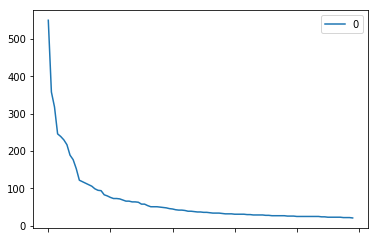

In [144]:
b1 = a1.iloc[1:100, :]
b1.plot()

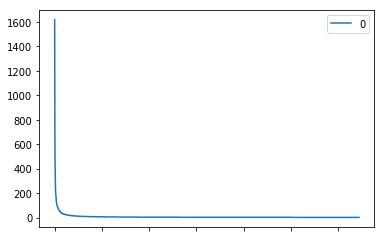

In [145]:
a2.plot()

In [146]:
b2 = a2.iloc[1:100, :]
b2.plot()

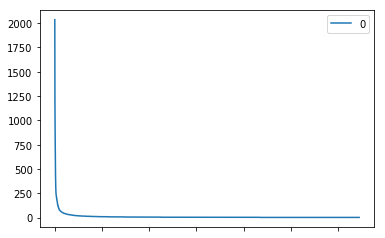

In [147]:
a3.plot()

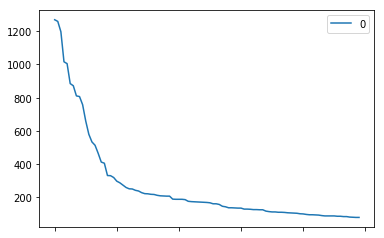

In [148]:
b3 = a3.iloc[1:100, :]
b3.plot()

# tf-idf 가중치 적용

In [149]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [150]:
#%%time 
train_feature_tfidf1 = transformer.fit_transform(train_feature_vector1)
train_feature_tfidf1.shape

(324, 6445)

In [151]:
%%time 
test_feature_tfidf1 = transformer.fit_transform(test_feature_vector1)
test_feature_tfidf1.shape

Wall time: 1 ms


In [152]:
#%%time 
train_feature_tfidf2 = transformer.fit_transform(train_feature_vector2)
train_feature_tfidf2.shape

(945, 6445)

In [153]:
%%time 
test_feature_tfidf2 = transformer.fit_transform(test_feature_vector2)
test_feature_tfidf2.shape

Wall time: 2 ms


In [154]:
#%%time 
train_feature_tfidf3 = transformer.fit_transform(train_feature_vector3)
train_feature_tfidf3.shape

(1440, 6445)

In [155]:
%%time 
test_feature_tfidf3 = transformer.fit_transform(test_feature_vector3)
test_feature_tfidf3.shape

Wall time: 2 ms


# 머신러닝 : 학습

In [156]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [157]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
# y_label3 = df_train['charge_pred']
y_label1 = df_train1['charge_pred']
%time forest = forest.fit(train_feature_tfidf1, y_label1)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 146 ms


In [158]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
# y_label3 = df_train['charge_pred']
y_label2 = df_train2['charge_pred']
%time forest = forest.fit(train_feature_tfidf2, y_label2)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 237 ms


In [159]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
# y_label3 = df_train['charge_pred']
y_label3 = df_train3['charge_pred']
%time forest = forest.fit(train_feature_tfidf3, y_label3)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

Wall time: 241 ms


# 모델평가

In [160]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score1 = cross_val_score(forest, train_feature_vector1, y_label1, cv=k_fold, n_jobs=-1, scoring=scoring)
score1

Wall time: 18.3 s


array([0.67692308, 0.76923077, 0.83076923, 0.84615385, 0.8125    ])

In [161]:
round(np.mean(score1)*100,2)

78.71

In [162]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score2 = cross_val_score(forest, train_feature_vector2, y_label2, cv=k_fold, n_jobs=-1, scoring=scoring)
score2

Wall time: 882 ms


array([0.85185185, 0.85714286, 0.91005291, 0.84126984, 0.86772487])

In [163]:
round(np.mean(score2)*100,2)

86.56

In [164]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score3 = cross_val_score(forest, train_feature_vector3, y_label3, cv=k_fold, n_jobs=-1, scoring=scoring)
score3

Wall time: 937 ms


array([0.9375    , 0.91666667, 0.92013889, 0.94791667, 0.91666667])

In [165]:
round(np.mean(score3)*100,2)

92.78

# 예측

In [166]:
# 테스트 데이터를 넣고 예측합니다.
y_pred1 = forest.predict(test_feature_vector1)
y_pred1[:3]

ValueError: Number of features of the model must match the input. Model n_features is 6445 and input n_features is 1468 

In [167]:
y_pred1.shape

NameError: name 'y_pred1' is not defined

In [83]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output1 = pd.DataFrame(data={'charge_pred':y_pred1})
output1.head(10)

charge_pred
0           N
1          구매
2           N
3           N
4           N
5           N
6          구매
7           N
8           N
9           N

In [84]:
df_test1['charge_pred'] = y_pred1

In [85]:
# 테스트 데이터를 넣고 예측합니다.
y_pred2 = forest.predict(test_feature_vector2)
y_pred2[:3]

array(['구매', '구매', 'N'], dtype=object)

In [86]:
y_pred2.shape

(657,)

In [87]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output2 = pd.DataFrame(data={'charge_pred':y_pred2})
output2.head(10)

charge_pred
0          구매
1          구매
2           N
3          구매
4           N
5           N
6           N
7           N
8           N
9           N

In [88]:
df_test2['charge_pred'] = y_pred2

In [89]:
# 테스트 데이터를 넣고 예측합니다.
y_pred3 = forest.predict(test_feature_vector3)
y_pred3[:3]

array(['N', 'N', 'N'], dtype=object)

In [90]:
y_pred3.shape

(712,)

In [91]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output3 = pd.DataFrame(data={'charge_pred':y_pred3})
output3.head(10)

charge_pred
0           N
1           N
2           N
3           N
4           N
5           N
6           N
7           N
8           N
9           N

In [92]:
df_test3['charge_pred'] = y_pred3

# 결과검증

In [93]:
df_test1['pred_diff'] = 0
df_test1['pred_diff'] = (df_test1['책임구'] == df_test1['charge_pred'] ) == 1
df_test1['pred_diff'] = df_test1['pred_diff'].astype(int)
df_test1.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd ceq_psit_nm  \
9535               W  2018     20181025         ZZ3         Q57   소음/이음_작동시   
9537               W  2016     20160907         ZZ3         Q57   소음/이음_작동시   
9538               W  2017     20170916         ZZ3         Q57   소음/이음_작동시   
9539               W  2015     20151126         ZZ3         Q57   소음/이음_작동시   
9541               W  2015     20150325         ZZ3         Q57   소음/이음_작동시   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
9535         KV11          CK     J5          TT        98350   
9537         KV11          YP     A9          TT        83940   
9538         KV11          YP     A9          TT        83940   
9539         KV11          YP     A9          TT        83810   
9541         KV11          YP     A9          BD        76003   

                                           clm_prtl_sbc 대상 선정 구분 책임구 원인  검토결과  \
9535      와이퍼브러쉬 작동시 소음 발생  유리 유막 제거후 에도 소음 계속 발생됨  ...     X  N   N  N  X---   
9537    JX          W       슬라이딩 도어 작동시 소음으로 입고원인 슬라...     X  N   N  N  X---   
9538       우측 슬라이딩도어 작동시 간헐적 소음 찌익    센터롤러 소음으로 판단되어 교환     X  N   N  N  X---   
9539    파워슬라이딩 도어 어셈블리 좌측 소손에 의한 작동중 삑삑삑  이음 발생됨점검후 ...     X  N   N  N  X---   
9541    프론트 도어 모듈패널 교환  운전석 윈도우 하강시     지점부터 항시 소음발생...     X  N   N  N  X---   

     charge_pred  pred_diff  
9535           N          1  
9537          구매          0  
9538           N          1  
9539           N          1  
9541           N          1

In [94]:
diff_sum1 = df_test1['pred_diff'].sum()
diff_sum1

473

In [95]:
y_pred_len1 = len(y_pred1)
y_pred_len1

588

In [96]:
df_test2['pred_diff'] = 0
df_test2['pred_diff'] = (df_test2['책임구'] == df_test2['charge_pred'] ) == 1
df_test2['pred_diff'] = df_test2['pred_diff'].astype(int)
df_test2.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd ceq_psit_nm  \
9441               W  2018     20180920         ZZ3         Q57   소음/이음_작동시   
9443               W  2015     20150119         ZZ3         Q57   소음/이음_작동시   
9444               W  2017     20171213         ZZ5         Q57   소음/이음_작동시   
9445               W  2016     20160202         ZZ3         Q57   소음/이음_작동시   
9446               W  2017     20170919         ZZ3         Q57   소음/이음_작동시   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
9441         KV11          YP     A9          TT        98350   
9443         KV11          YP     A9          TT        82210   
9444         KV11          YP     A9          TT        98350   
9445         KV11          YP     A9          AC        93480   
9446         KV11          YP     A9          TT        81770   

                                           clm_prtl_sbc 대상 선정 구분 책임구 원인  검토결과  \
9441    와이퍼 작동시 하강시에 소음발생및 중앙부 안닦힘 드드득   조치 운전석 와이퍼 ...     X  N   N  N  X---   
9443      윈도우 글라스 상 하 작동 시 소음점검   윈도우 글라스 소음 유무 확인점검...     X  N   N  N  X---   
9444        와이퍼 잘안닦임으로 입고  점검내용및원인  전면유리 이물질 및데미지 않음...     X  N   N  N  X---   
9445     ABS 경고등 점등 점검 조향각 센서 작동 불량으로 인한 경고등 점등 조치 조...     X  N   N  N  X---   
9446                                태일게이트열림시소음발생되어교환조치함     X  N   N  N  X---   

     charge_pred  pred_diff  
9441          구매          0  
9443          구매          0  
9444           N          1  
9445          구매          0  
9446           N          1

In [97]:
diff_sum2 = df_test2['pred_diff'].sum()
diff_sum2

546

In [98]:
y_pred_len2 = len(y_pred2)
y_pred_len2

657

In [99]:
df_test3['pred_diff'] = (df_test3['책임구'] == df_test3['charge_pred'] ) == 1
df_test3['pred_diff'] = df_test3['pred_diff'].astype(int)
df_test3.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd ceq_psit_nm  \
9376               W  2015     20150408         ZZ5         Q57   소음/이음_작동시   
9378               W  2015     20150217         ZZ5         Q57   소음/이음_작동시   
9379               W  2016     20161019         ZZ5         Q57   소음/이음_작동시   
9381               W  2017     20170628         ZZ5         Q57   소음/이음_작동시   
9382               W  2018     20180706         ZZ5         Q57   소음/이음_작동시   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
9376         KV11          YP     A9          TT        81770   
9378         KV11          YP     A9          TT        82530   
9379         KV11          YP     A9          TT        83940   
9381         KV11          YP     A9          TT        84660   
9382         KV11          YP     A9          TT        98350   

                                           clm_prtl_sbc 대상 선정 구분 책임구 원인  검토결과  \
9376        파워 테일게이트 닫을시 부드럽지 않으며 세게 닫히며 튕김  점검   수동...     X  N   N  N  X---   
9378             글라스런체널작동시소음건프론트좌측 글라스런체널 상하작동시소음발생으로교환     X  N   N  N  X---   
9379                                싸이드 도어 작동후 닫힘시 이음발생     X  N   N  N  X---   
9381                      콘솔암레스트에 팔을 올려놓고 주행중 소음  삐걱삐걱      X  N   N  N  X---   
9382           와이퍼 작동시 소음  와이퍼 블레이드 부품불량  와이퍼 블레이드 부품교환     X  N   N  N  X---   

     charge_pred  pred_diff  
9376           N          1  
9378           N          1  
9379           N          1  
9381           N          1  
9382           N          1

In [100]:
diff_sum3 = df_test3['pred_diff'].sum()
diff_sum3

601

In [101]:
y_pred_len3 = len(y_pred3)
y_pred_len3

712

# 정확도

In [102]:
Acy1 = round(diff_sum1/y_pred_len1*100,1)
Acy1

80.4

In [103]:
Acy2 = round(diff_sum2/y_pred_len2*100,1)
Acy2

83.1

In [104]:
Acy3 = round(diff_sum3/y_pred_len3*100,1)
Acy3

84.4